# Predicting Log Error of the Zestimate®


## Author:
Christopher Mayorga, Jr. Data Scientist
christopher.mayorga2@gmail.com

## Date:
June 21, 2021

## Project Goals:
Create insight for the current Zillow Zestimate model by predicting the model's log error.

## Conclusions:
- Did not find linear correlations of features with respect to Log Error.
- Final Model performs well, but not better than the baseline.
- Tried Linear Regression and Polynomial Linear Regression models, are there other models that can be used? Other features?

# Table of Contents:
*Acquire* - Use acquire module to assign the data to a variable

*Prepare* - Use prepare module to clean the data

*Explore* - Highlight key takeaways from explore

*Modeling* - Creating 4 models to predict log error and determining the best performing one

*Conclusions* - Reasons for log error, best model to predict log error*



# Acquire
- If you would like to see the data before prep, run acquire function
- However, this function is also within the Prepare.py module
calling the Prepare.prepare_zillow() function will use Acquire to obtain the data and prep in one function
- The query in Acquire joins the predictions_2017 and properties_2017 tables, and selects only single-unit properties

In [1]:
# Acquire.py holds functions to connect to sql database, and return a df with data selected with query
import Acquire

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_df = Acquire.get_home_data()

## The original data has 61 columns and 70,364 rows. There is also more that 50% of nulls in many columns.

In [3]:
raw_df.shape

(70364, 61)

In [4]:
raw_df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       50658
architecturalstyletypeid    70213
basementsqft                70320
                            ...  
taxdelinquencyflag          69043
taxdelinquencyyear          69043
censustractandblock          1590
logerror                        0
transactiondate                 0
Length: 61, dtype: int64

Max tax amount: 1824154.85


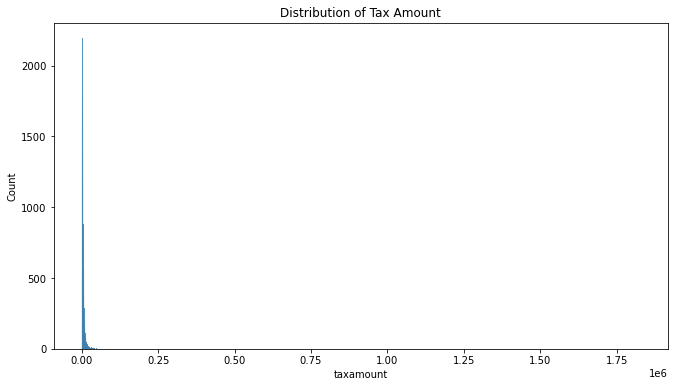

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# An Example of One Feature Before Removing Outliers

# Plotting histogram of Tax Amount
plt.figure(figsize=(11,6))
sns.histplot(raw_df.taxamount)
plt.title('Distribution of Tax Amount')

# Checking the maximum value of the feature
print('Max tax amount:', raw_df.taxamount.max())


# Acquire Takeaways
- large amount of nulls
- outliers present
- new features can be created
- columns need to be renamed, rearranged

# Prepare 
Within the prepare function:

- columns and rows with more than %25 of nulls are removed
- uneccessary columns are removed (such as multiple sqft)
- outliers in continuous variables are removed
- leftover nulls are filled with mean or mode
- features for property age and transaction month are created
- columns are renamed and rearranged


## Prepare.py also splits the data into train, validate, test

70% Train, 20% Validate, 10% Test

In [6]:
# Prepare.py holds the function to obtain the data, prep the data, and split into train, validate, test
import Prepare

In [7]:
# prepare_zillow function acquires the raw data, cleans, and splits the df, returning train, validate, split
train, validate, test = Prepare.prepare_zillow()

train shape:  (44284, 24) , validate shape:  (12491, 24) , test shape:  (6309, 24)

train percent:  70.0 , validate percent:  20.0 , test percent:  10.0


## The Split Data Frame After Prepare

In [8]:
train.head(1).T

,35177
parcel_id,12881510
log_error,-0.080165
tax_value,114424
structure_tax_value,52011
land_tax_value,62413
tax_amount,1624.52
tax_rate,1.41974
county_id,6037
zip_code,96507
latitude,3.40614e+07


**No nulls are left after using the prepare function**

In [9]:
train.isnull().sum()

parcel_id              0
log_error              0
tax_value              0
structure_tax_value    0
land_tax_value         0
tax_amount             0
tax_rate               0
county_id              0
zip_code               0
latitude               0
longitude              0
census_id              0
bathrooms              0
bedrooms               0
full_bathrooms         0
bed_plus_bath          0
room_count             0
property_sqft          0
lot_sqft               0
land_use_type          0
year_built             0
property_age           0
transaction_date       0
transaction_month      0
dtype: int64

Max tax amount of train: 342940.38


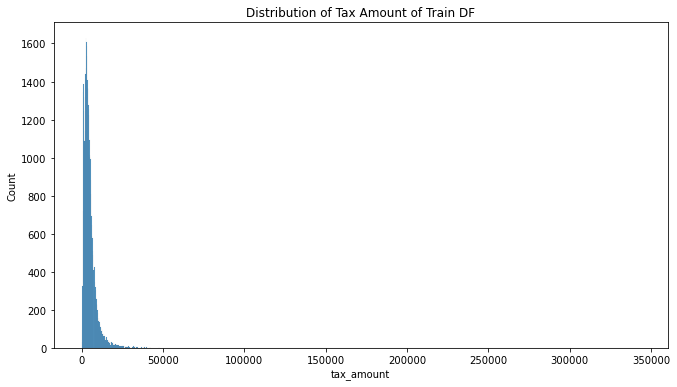

In [10]:
# Same Feature from Acquire Plotted - After Prep and Split into Train

# Plotting train Tax Amount
plt.figure(figsize=(11,6))
sns.histplot(train.tax_amount)
plt.title('Distribution of Tax Amount of Train DF')

# Checking the maximum value of the feature
print('Max tax amount of train:', train.tax_amount.max())

# Prepare Takeaways
- Data has been cleaned as specified in Acquire
- Data is split, but not scaled so we can explore
- X and y dataframes have not been seperated yet
- Will need to be scaled before creating clusters and modeling


# Explore

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Visualizing Independent Feature vs. Log Error in Google Sheets
Link: https://docs.google.com/spreadsheets/d/1L1pT1EfbaicnS8WmlqVL2XaCOFuH1y4mNfWc4Jpinh4/edit?usp=sharing

In [12]:
# to use split data while exploring in Google Sheets
# train.to_csv('zillow_train.csv')

<img src="images/Property_Square Feet_vs Logerror.png" alt="columns" width="500"/>

Takeaway: Logerror is more spread out among properties with a lower square feet.

<img src="images/Avg_Logerror_vs._Month.png" alt="columns" width="500"/>

Takeaway: A polynomial model might be a good fit for average of logerror and transaction month.

<img src="images/Avg. Log Error by Year Built.png" alt="columns" width="500"/>

Takeaway: Logerror seems to increase around 1940 through 2000.

## Testing Features with Hypothesis Tests

### Transaction Month
- One-Sample, T-test for May vs. Population Mean
- Reject Null hypothesis, significant difference found
- p-value: .03

### Sqft
- Correlation test for Sqft vs. Log Error
- Fail to Reject Null hypothesis, no linear correlation
- p-value: 0.77

### Year Built
- Correlation test for Year built vs. Log Error
- Fail to Reject Null hypothesis, no linear correlation
- When controlled for popular years (1946-1990) p-value decreased
- p-value from 0.45061 to 0.1091


### Testing Transaction Month With Hypothesis Testing
**One-Sample, One-Tailed T-test**
Test transaction month 5 (May) against the population

$H_O$: There is no significant difference between log error in May and all months.

$H_A$: Log Error in May is significantly different than log error in all months.



In [15]:
# import One-sample, t-test
from scipy.stats import ttest_1samp

# Transactions in 05 - May
May_train = train[train.transaction_month == 5]

# Population Average
pop_mean = train.log_error.mean()

In [29]:
from math import sqrt
from scipy import stats

alpha = 0.05

# 1 sample t-test to compute t and p
t, p = stats.ttest_1samp(May_train.log_error, pop_mean)


In [44]:
print('Transaction Month One-Sample, One-Tailed T-Test')
print('t-score:    ',round(t,2))
print('p-value:     ',round(p,2))
print('Reject null hypothesis.')

Transaction Month One-Sample, One-Tailed T-Test
t-score:     -2.23
p-value:      0.03
Reject null hypothesis.


### Property Square Feet With Hypothesis Testing
**Correlation Test**

Testing correlation of Property Sqft and Log Error.

$H_O$: There is no linear correlation between property sqft and log error.

$H_A$: There is a linear correlation between property sqft and log error.

**Failed to reject null hypothesis.**

In [46]:
# p-value must be lower than alpha to reject null hypothesis
alpha = .05

r, p = stats.pearsonr(train.property_sqft, train.log_error)

In [47]:
print('Correlation Test on SQFT Built')
print('     p-value:',round(p,5))
print('     r-value:',round(r,5))
print('Fail to reject null hypothesis.')
print('Low r suggests might have non-linear correlation.\n\n')

Correlation Test on SQFT Built
     p-value: 0.72977
     r-value: 0.00164
Fail to reject null hypothesis.
Low r suggests might have non-linear correlation.




### Year Built with Hypothesis Testing

**Correlation Test**

Testing correlation of year built with all observations

$H_O$: There is no linear correlation between year built and log error.

$H_A$: There is a linear correlation between year built and log error.

**Failed to reject null hypothesis**

In [48]:
# import correlation test
from scipy.stats import pearsonr

# p-value must be lower than alpha to reject null hypothesis
alpha = .05

r, p = stats.pearsonr(train.year_built, train.log_error)

In [49]:
print('Correlation Test on All Year Built')
print('     p-value:',round(p,5))
print('     r-value:',round(r,5))
print('Fail to reject null hypothesis.')
print('Low r suggests might have non-linear correlation.\n\n')

Correlation Test on All Year Built
     p-value: 0.45061
     r-value: -0.00359
Fail to reject null hypothesis.
Low r suggests might have non-linear correlation.




### Year Built with Hypothesis Testing

**Correlation Test**

Testing correlation of year built from years with high observations (1946 - 1990)

$H_O$: There is no linear correlation between year built and log error.

$H_A$: There is a linear correlation between year built and log error.

**Failed to reject null hypothesis**

In [50]:
# properties with year built between 1946 and 1990)
years_46_90 = train[(train.year_built > 1946) & (train.year_built < 1990)]

r2, p2 = stats.pearsonr(years_46_90.year_built, years_46_90.log_error)

In [51]:
print('Correlation Test on Year Built (1946-1990)')
print('     p-value:',round(p2,5))
print('     r-value:',round(r2,5))
print('Fail to reject null hypothesis.')
print('Low r suggests might have non-linear correlation.')

Correlation Test on Year Built (1946-1990)
     p-value: 0.1091
     r-value: -0.00909
Fail to reject null hypothesis.
Low r suggests might have non-linear correlation.


## Visualizing Clusters in Google Sheets
Link: https://docs.google.com/spreadsheets/d/1MOjXZUKZpPLdFcG_yGrMpEddmrrbB_GO258yovHT54E/edit?usp=sharing

In [55]:
import Model
# created clusters with unscaled data to visualize clusters in Tableau
train, validate, test = Model.create_clusters(train, validate, test)

#train.to_csv('zillow_clusters.csv')

<img src="images/Tax Cluster.png" alt="columns" width="1000"/>

**Cluster created with KMeans on Tax Value, Tax Amount, and Tax Rate**

<img src="images/Sqft Cluster.png" alt="columns" width="1000"/>

**Cluster created with KMeans on Property and Lot Sqft**

<img src="images/Room Cluster.png" alt="columns" width="1000"/>

**Cluster created with KMeans on Bath+Bed Count, Full Bath Count, Room Count, and Property Age.**

## Testing Clusters with Hypothesis Testing - ANOVA Test

$H_O$: There is no signficant difference between the log error means of each cluster group.

$H_A$: There is a signficant difference between the log error means of at least two cluster groups.

### Tax Cluster
- Fail to Reject Null Hypothesis
- p-value of 0.7519

### Sqft Cluster
- Fail to Reject Null Hypothesis
- p-value of 0.7735

### Room/Age Cluster
- Fail to Reject Null Hypothesis
- p-value of 0.6641

### Tax Cluster with Hypothesis Testing

**ANOVA Test on Tax Cluster**

$H_O$: There is no signficant difference between the log error means of each cluster.

$H_A$: There is a signficant difference between the log error means of at least two clusters.

In [76]:
import scipy.stats as stats

In [78]:
alpha = 0.05

F, p = stats.f_oneway(train[train.cluster_tax == 0].log_error,
                      train[train.cluster_tax == 1].log_error,
                      train[train.cluster_tax == 2].log_error,
                      train[train.cluster_tax == 3].log_error)

if p < alpha:
    print('We reject the null hypothesis\n')
else:
    print('We fail to reject the null hypothesis\n')

print('Anova Test Results on Tax Cluster')
print('F-value:',round(F,2))
print('P-value:',round(p,2))

We fail to reject the null hypothesis

Anova Test Results on Tax Cluster
F-value: 0.37
P-value: 0.77


### SQFT Cluster with Hypothesis Testing

**ANOVA Test on SQFT Cluster**

$H_O$: There is no signficant difference between the log error means of each cluster.

$H_A$: There is a signficant difference between the log error means of at least two clusters.

In [80]:
alpha = 0.05

F, p = stats.f_oneway(train[train.cluster_sqft == 0].log_error,
                      train[train.cluster_sqft == 1].log_error,
                      train[train.cluster_sqft == 2].log_error,
                      train[train.cluster_sqft == 3].log_error,
                      train[train.cluster_sqft == 4].log_error)

if p < alpha:
    print('We reject the null hypothesis\n')
else:
    print('We fail to reject the null hypothesis\n')

print('Anova Test Results on SQFT Cluster')
print('F-value:',round(F,2))
print('P-value:',round(p,2))

We fail to reject the null hypothesis

Anova Test Results on SQFT Cluster
F-value: 0.07
P-value: 0.99


### Room/Age Cluster with Hypothesis Testing

**ANOVA Test on Room/Age Cluster**

$H_O$: There is no signficant difference between the log error means of each cluster.

$H_A$: There is a signficant difference between the log error means of at least two clusters.

In [81]:
alpha = 0.05

F, p = stats.f_oneway(train[train.cluster_rooms == 0].log_error,
                      train[train.cluster_rooms == 1].log_error,
                      train[train.cluster_rooms == 2].log_error,
                      train[train.cluster_rooms == 3].log_error,
                      train[train.cluster_rooms == 4].log_error)

if p < alpha:
    print('We reject the null hypothesis\n')
else:
    print('We fail to reject the null hypothesis\n')

print('Anova Test Results on Room/Age Cluster')
print('F-value:',F)
print('P-value:',p)

We fail to reject the null hypothesis

Anova Test Results on Room/Age Cluster
F-value: 0.8040076606304343
P-value: 0.5223527311794829


# Explore Takeaways

Features

- Independent features explored did not have linear correlation
- Visually can see non-linear correlation with transaction month

Clusters

- No clusters had significant difference within their groupings
- Used Elbow method to select features, but some groupings still had very little observations - narrow down k
- Further testing with different features is needed to determine if there are significant clusters

# Modeling - Predicting Log Error

In [82]:
# imports to calculate model metrics
from sklearn.metrics import mean_squared_error, explained_variance_score

In [83]:
# Scale data with prepare function - DROPS LOG ERROR
train_scaled, validate_scaled, test_scaled = Prepare.scale_data(train, validate, test)

In [84]:
# Add clusters
train_scaled, validate_scaled, test_scaled = Model.create_clusters(train_scaled, validate_scaled, test_scaled)

In [85]:
# split into X variables and y target

# X is every column except log_error
X_train = train_scaled
# y is only log error, [[]] to keep as df and not series
y_train = train[['log_error']]

# repeat for validate and test
X_validate = validate_scaled
y_validate = validate[['log_error']]

X_test = test_scaled
y_test = test[['log_error']]

## Baseline Model
Will predict the same log error for each observation, either average, median, or mode

In [86]:
# printing stats to determine baseline
print('Log Error Stats\n')
print('average:', round(train.log_error.mean(),6))
print('mode:   ', round(train.log_error.mode()[0],6))
print('median: ', round(train.log_error.median(),6))

Log Error Stats

average: 0.016236
mode:    0.002652
median:  0.006571


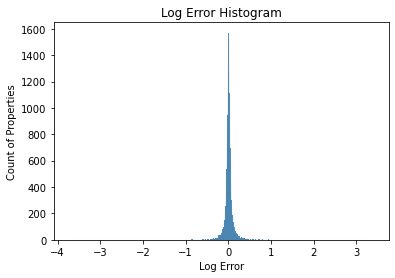

In [88]:
# distribution of log error, to help determine baseline along with stats
plt.title('Log Error Histogram')
plt.xlabel('Log Error')
plt.ylabel('Count of Properties')
sns.histplot(train.log_error)

plt.show()

### Log error is normally distributed, will create baseline as the average

In [90]:
# setting baseline to average log_error
baseline = train.log_error.mean()

# calculating MSE with y_train (actual) and baseline (extended to same size as df)
baseline_mse = mean_squared_error(y_train, np.full(y_train.shape, baseline))
baseline_rmse = baseline_mse**1/2

print('The Baseline Mean Squared Error:', round(baseline_mse,3))
print('The Baseline Root Mean Squared Error:', round(baseline_rmse,3))

The Baseline Mean Squared Error: 0.028
The Baseline Root Mean Squared Error: 0.014


## Creating Models on Train

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures

#### Model 1
Using Linear Regression Model on All Features

In [92]:
lm1 = LinearRegression()
lm1.fit(X_train, y_train.log_error)
y_hat = lm1.predict(X_train)

y_train['lm_1'] = y_hat

mean_squared_error(y_train.log_error, y_hat)**(1/2)

0.16853065950623417

### Using SelectKBest to Determine Features with Highest Linear Correlation to Log Error¶

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features to select
rfe = RFE(lm, 9)

# fit the data using RFE
rfe.fit(X_train,y_train.log_error)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()

In [94]:
# Features elected by SelectKBest
print('SelectKBest Top 9 Features:')
rfe_feature

SelectKBest Top 9 Features:


['tax_value',
 'land_tax_value',
 'tax_amount',
 'bathrooms',
 'bedrooms',
 'full_bathrooms',
 'bed_plus_bath',
 'property_sqft',
 'property_age']

#### Model 2
Use Linear Regression with Features from SelectKBest

In [95]:
X_train_2 = train_scaled[['tax_value','land_tax_value','tax_amount','bathrooms',
                          'bedrooms','full_bathrooms','bed_plus_bath',
                          'property_sqft','year_built']]

lm2 = LinearRegression()
lm2.fit(X_train_2, y_train.log_error)
y_hat = lm2.predict(X_train_2)

y_train['lm_2'] = y_hat

mean_squared_error(y_train.log_error, y_hat)**(1/2)

0.16854030710302584

#### Model 3
Using Polynomial LinearRegression on All Features

In [96]:
# make the polynomial features to get a new set of features
pf1 = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2 = pf1.fit_transform(X_train)

# create the model object
lmP1 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lmP1.fit(X_train_degree2, y_train.log_error)

# predict train
y_train['poly_1'] = lmP1.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.log_error, y_train.poly_1)**1/2

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.01354856259315104


#### Model 4
Using Polynomial with degree of 3 and selected features

In [97]:
# make the polynomial features to get a new set of features
pf2 = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2 = pf2.fit_transform(X_train_2)

# create the model object
lmP2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lmP2.fit(X_train_degree2, y_train.log_error)

# predict train
y_train['poly_2'] = lmP2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.log_error, y_train.poly_2)**1/2

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.014163436688277672


## Are Models Overfit? Checking with Validate

### Validate on Linear Regression Model with All Features

In [98]:
y_hat = lm1.predict(X_validate)

mean_squared_error(y_validate.log_error, y_hat)**(1/2)

0.17303578072724218

### Validate on Polynomial Degrees=3 Model with All Features

In [99]:
X_validate_degree2 = pf1.transform(X_validate)

# predict validate
y_validate['poly_1'] = lmP1.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = (mean_squared_error(y_validate.log_error, y_validate.poly_1))**(1/2)

rmse_validate

1717376152.4070976

### Validate on Polynomial Degrees=3 Model with Selected Features

In [100]:
X_validate_2 = validate_scaled[['tax_value','land_tax_value','tax_amount',
                                'bathrooms','bedrooms','full_bathrooms',
                                'bed_plus_bath','property_sqft','year_built']]

X_validate_degree2 = pf2.transform(X_validate_2)

# predict validate
y_validate['poly_2'] = lmP2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = (mean_squared_error(y_validate.log_error, y_validate.poly_2))**(1/2)

rmse_validate

0.21491611722101744

## Simulating Future, Unseen Data - Best Model on Test

### Polynomial with Degree = 3 on Select Features

In [101]:
X_test_2 = test_scaled[['tax_value','land_tax_value','tax_amount',
                                'bathrooms','bedrooms','full_bathrooms',
                                'bed_plus_bath','property_sqft','year_built']]

X_test_degree2 = pf2.transform(X_test_2)

# predict validate
y_test['poly_2'] = lmP2.predict(X_test_degree2)

# evaluate: rmse
rmse_validate = (mean_squared_error(y_test.log_error, y_test.poly_2))**(1/2)

rmse_validate

0.318371009183217

# Performance of Final Model Selected

## PolynomialFeatures + LinearRegression, Degree = 3, 9 SelectKBest Features

### Train
RMSE: 0.01416

### Validate
RMSE: 0.21492

### Test
RMSE: 0.31837

### *Baseline*
RMSE: 0.01421

# Modeling Takeaways
- Polynomial Models appeared to outperform on train, but did worse on validate/test
- Linear Regression did not outperform the baseline, but stayed more consistent between train and validate
- Can different clusters be made to help the models?


# Conclusions
- With SQFT and Year Built - where there are more observations, there is more log error
- Features did not have any linear correlations
- Clusters were not significant, did not improve modeling
- Linear Regression with Polynomials of 3rd Degree perfromed better than baseline on train, but not validate or test

# Next Steps
- More analysis on features to determine non-linear correlation
- Try using SelectKBest to create a cluster
- Need to improve models by trying different clusters/features and algorithms